In [4]:
#imports and cwd
import numpy as np
from cv2 import cv2
import os
import matplotlib.pyplot as plt
import pickle
import scipy.optimize as opt
import scipy.stats as sts
import math
import vifida as vif

os.chdir("\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration")

In [5]:
#load calibration
cFile = open('M0.cal', 'rb')
[ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo] = pickle.load(cFile)
cFile.close()


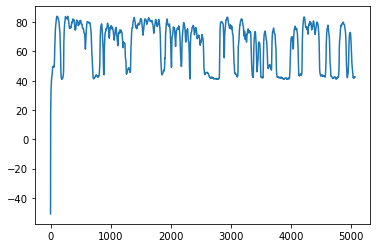

In [6]:
#Create a set of instructions from audio with the naive approach
slowFactor = 4
framerate = 25

wavfilepath = "\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\sol.WAV"
#framerate*slowfactor accounts for the fact of recording at a lower speed
#it is only used here, from this point we work at the actual recording speed
sensed, samplerate, duration = vif.wavToSensed(wavfilepath,framerate*slowFactor,forceMono=True)

plt.plot(sensed)


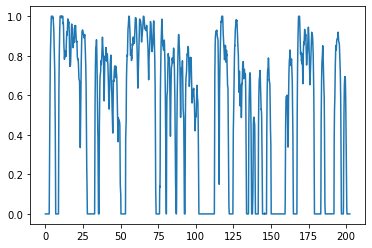

In [7]:
#adjust the variables to get nice dinamycs
drive = vif.sensedToFuzzy(sensed,thres=42,k=1.15)
time = np.linspace(0,len(drive)-1,len(drive),dtype="float64")/framerate

plt.plot(time,drive)

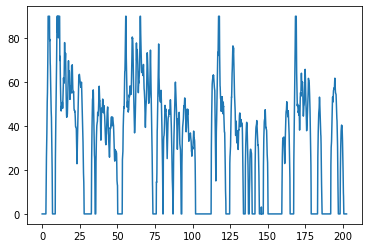

In [8]:
#visualise it angularly
ideal = signal2cresc(drive)*90

plt.plot(time,ideal)

Number of speeds unreachable:
153
Fraction unreachable:
0.0302


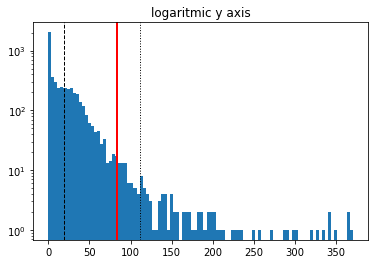

In [9]:
#study speed distributions
idealSpeeds=np.zeros( (len(ideal)-1,1) )

for i in range(len(idealSpeeds)):
    idealSpeeds[i]=(ideal[i+1]-ideal[i])*framerate

absIS=abs(idealSpeeds)

#compare to reachable speeds
absInputs=np.linspace(1,14,14)
absSpeeds=absInputs*ieq

plt.hist(absIS,bins = 100)
plt.axvline(absIS.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(absSpeeds.max(), color='red', linestyle='-', linewidth=2)
plt.axvline(absIS.mean()+3*absIS.std(), color='k', linestyle='dotted', linewidth=1)
plt.yscale('log')
plt.title("logaritmic y axis")

print("Number of speeds unreachable:")
print(sum(absIS>absSpeeds.max())[0])
print("Fraction unreachable:")
print(round((sum(absIS>absSpeeds.max())/len(absIS))[0],4))


Typical angular error:
2.4
Max angular error:
17.8


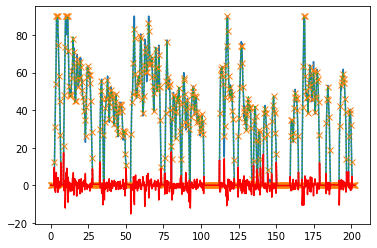

In [10]:
#fisrt approach: fixed number of movements N
N=460
orders=np.zeros((N+1,2))

#Inicialization
ind=np.linspace(0,len(ideal)-1,N+1,dtype='int')
controlIdeal=ideal[ind]
controlTime=time[ind]

for i in range(N):
    """ thisInd = ind[i]
    nextInd = ind[i+1]
    thisTime = (nextInd*1.0-thisInd*1.0)/framerate """
    thisTime = controlTime[i+1]-controlTime[i]

    #speed
    """ orders[i,0]=(ideal[nextInd]-ideal[thisInd])/thisTime """
    orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
    orders[i,0]=round(orders[i,0]/ieq)
    if orders[i,0] > 14:
        orders[i,0] = 14
    elif orders[i,0] < -14:
        orders[i,0] = -14

    #steps
    if orders[i,0] == 0:
        orders[i,1]=round(thisTime*1000)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]
    else :
        orders[i,1]=abs(orders[i,0]*ieq)*thisTime
        orders[i,1]=round(orders[i,1]/seq)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

#Reconstruction visualization:
rebuilt=np.zeros_like(ideal)
thisInd=0
for i in range(orders.shape[0]):
    thisI=orders[i,0]
    thisS=orders[i,1]
    if thisI==0:
        if thisS==0:
            break
        else: #if v==0, s are waiting time in ms
            nextInd= round(thisInd+thisS/1000*framerate).astype('int')
            interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
    else:
        thisTime= thisS*seq / (abs(thisI)*ieq)
        #print(thisTime)
        nextInd= thisInd + thisTime*framerate
        nextInd= round(nextInd).astype('int')
        interval=np.linspace(rebuilt[thisInd],
        rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
        nextInd-thisInd+1)
    
    rebuilt[thisInd:nextInd+1]=interval.flatten()
    thisInd=nextInd


plt.plot(time,ideal)
plt.plot(time[ind],ideal[ind],linestyle='',marker='x')
plt.plot(time,rebuilt,linestyle=':')
plt.plot(time,rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

In [11]:
def naiveOrders(slowFactor,N,framerate,wavfilepath,thres=42,k=1.15):
    sensed, samplerate, duration = vif.wavToSensed(wavfilepath,framerate*slowFactor,forceMono=True)
    drive = vif.sensedToFuzzy(sensed,thres=thres,k=k)
    time = np.linspace(0,len(drive)-1,len(drive),dtype="float64")/framerate
    ideal = signal2cresc(drive)*90
    print(ieq)
    #Setup:
    orders=np.zeros((N+1,2))
    ind=np.linspace(0,len(ideal)-1,N+1,dtype='int')
    controlIdeal=ideal[ind]
    controlTime=time[ind]

    #Define orders:
    for i in range(N):
        thisTime = controlTime[i+1]-controlTime[i]
        #speed
        orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
        orders[i,0]=round(orders[i,0]*ieq)
        if orders[i,0] > 14:
            orders[i,0] = 14
        elif orders[i,0] < -14:
            orders[i,0] = -14
        #steps
        if orders[i,0] == 0:
            orders[i,1]=round(thisTime*1000)
            #update control point
            controlIdeal[i+1]=controlIdeal[i]
        else :
            orders[i,1]=abs(orders[i,0]/ieq)*thisTime
            orders[i,1]=round(orders[i,1]/seq)
            #update control point
            controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq
    #Reconstruction:
    rebuilt=np.zeros_like(ideal)
    thisInd=0
    for i in range(orders.shape[0]):
        thisI=orders[i,0]
        thisS=orders[i,1]
        if thisI==0:
            if thisS==0:
                break
            else: #if v==0, s are waiting time in ms
                nextInd= round(thisInd+thisS/1000*framerate).astype('int')
                interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
        else:
            thisTime= thisS*seq / (abs(thisI)/ieq)
            #print(thisTime)
            nextInd= thisInd + thisTime*framerate
            nextInd= round(nextInd).astype('int')
            interval=np.linspace(rebuilt[thisInd],rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,nextInd-thisInd+1)
        
        rebuilt[thisInd:nextInd+1]=interval.flatten()
        thisInd=nextInd
    #Return MSE (error):
    return np.mean(np.power((rebuilt-ideal),2))

#brute force optimization of parameters
""" best=[math.inf,None,None]
slowes=np.linspace(2,5,4,dtype=int)
enes=np.linspace(200,700,501,dtype=int)
for slow in slowes:
    for N in enes:
        try:
            aux=naiveOrders(slow,N,framerate,wavfilepath,thres=42,k=1.15)
        except ValueError:
            print(slow,N)
        if best[0]>aux:
            best[0]=aux
            best[1]=slow
            best[2]=N
print(best) """

' best=[math.inf,None,None]\nslowes=np.linspace(2,5,4,dtype=int)\nenes=np.linspace(200,700,501,dtype=int)\nfor slow in slowes:\n    for N in enes:\n        try:\n            aux=naiveOrders(slow,N,framerate,wavfilepath,thres=42,k=1.15)\n        except ValueError:\n            print(slow,N)\n        if best[0]>aux:\n            best[0]=aux\n            best[1]=slow\n            best[2]=N\nprint(best) '

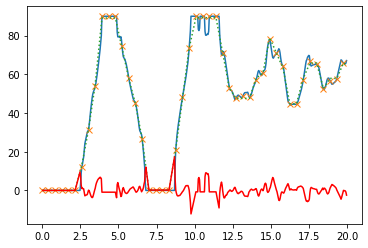

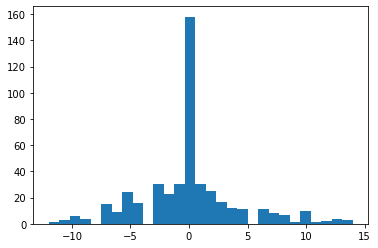

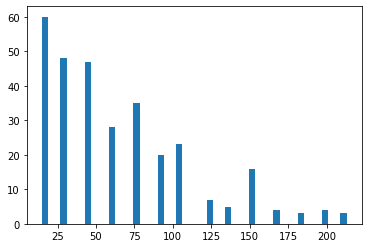

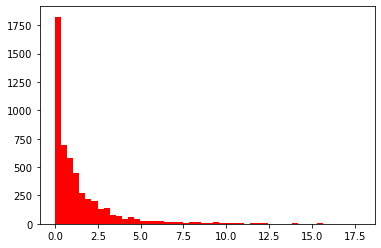

In [12]:
#zoom the first 20 seconds
aux2=500
plt.plot(time[1:aux2],ideal[1:aux2])
plt.plot(time[ind[ind<aux2]],ideal[ind[ind<aux2]],linestyle='',marker='x')
plt.plot(time[1:aux2],rebuilt[1:aux2],linestyle=':')
plt.plot(time[1:aux2],rebuilt[1:aux2]-ideal[1:aux2],color='red')
plt.show()

#velocity distribution
plt.hist(orders[:,0],bins=29)
plt.show()

#step number distribution
plt.hist(orders[orders[:,0]!=0,1],bins=50)
plt.show()

#error distribution
plt.hist(abs(rebuilt-ideal),bins=50,color='red')
plt.show()


In [13]:
#Create instructions
""" small_stepper.setSpeed(1.0000);
small_stepper.step(0);
delay(2000); """

#make sure the file is empty
f = open('instructions.txt', 'w')
f.close()

#write instructions
f = open('instructions.txt', 'a')

for i in range(len(orders)):
    if orders[i,0]!=0:
        f.write("small_stepper.setSpeed(")
        f.write(str(int(abs(orders[i,0]))))
        f.write(");\n")
        f.write("small_stepper.step(")
        f.write(str(int( math.copysign(orders[i,1],orders[i,0]) )))
        f.write(");\n")
    else:
        if orders[i,1]==0:
            break
        else:
            f.write("delay(")
            f.write(str(int( orders[i,1] )))
            f.write(");\n")
f.close()


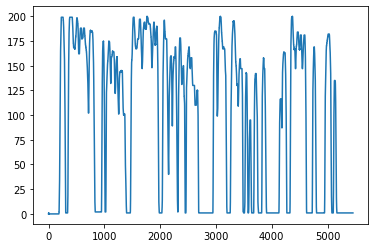

In [15]:
#Study recorded video
vidcap = cv2.VideoCapture('./sol_4x_460_20210621.MOV')
success,image = vidcap.read()
count = 0
meanBGR=np.zeros([1,1,3],dtype='uint8')
aux=np.zeros([1,1,3],dtype='uint8')
while success :
    for i in range(3):
        aux[0,0,i]=np.mean(image[:,:,i].flatten())
    meanBGR=np.append(meanBGR,aux,1)
    success,image = vidcap.read()
    if cv2.waitKey(10) == 27:                     # exit if Escape is hit
        break
    count += 1
meanBGR=meanBGR[:,1:count+1,:]
meanLAB=cv2.cvtColor(meanBGR, cv2.COLOR_BGR2LAB)
measured=meanLAB[:,:,0].flatten()

plt.plot(measured)


Typical lightness error:
4.28


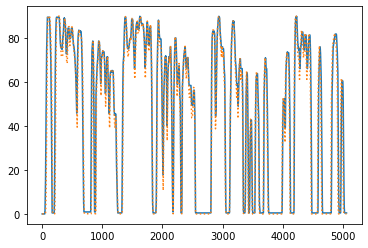

In [25]:
#Compare with the expected result
recorded=(measured-min(measured))/max(measured)*90
#Synchronize
overframe=len(recorded)-len(rebuilt)
optimalSync=[math.inf,0,0]
for i in range(overframe):
    aux=np.append(np.zeros((i,1)),rebuilt)
    aux=np.append(aux,np.zeros((overframe-i,1)))
    
    thisErr=np.mean(np.power(aux-recorded,2))
    if thisErr<optimalSync[0]:
        optimalSync[0]=thisErr
        optimalSync[1]=i
        optimalSync[2]=overframe-i
    del(aux)

comp=rebuilt-min(rebuilt)
comp=comp/max(comp)
comp=cresc2signal(comp)*90
    
recSync=recorded[optimalSync[1]:len(recorded)-optimalSync[2]]
plt.plot(recSync)
plt.plot(comp,linestyle=':')

print("Typical lightness error:")
print(round(np.mean(np.sqrt(np.power(recSync-comp,2))),2))
#Wow, error in the limit of perception already!

In [27]:
#Write video at higher framerate
vidcap = cv2.VideoCapture('./sol_4x_460_20210621.MOV')
success,image = vidcap.read()
count=1

cvcodec = cv2.VideoWriter_fourcc(*'avc1')
tempfilepath="\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\temp.mp4"
video = cv2.VideoWriter(tempfilepath,cvcodec,framerate*slowFactor,(image.shape[1],image.shape[0]))    

while success :
    if count>optimalSync[1]:
        video.write(image) #writes frame
        success,image = vidcap.read()
        count=count+1
        if count>len(recSync)+optimalSync[1]:
            break        
    else:
        success,image = vidcap.read()
        count=count+1

video.release()

outfilepath='./sol_output_100fps_20210621.mp4'
audiofilepath="\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\sol.MP3"
vif.writeOutputFile(outfilepath,tempfilepath,audiofilepath,codec='libx264')

t:   0%|          | 0/5060 [00:00<?, ?it/s, now=None]Moviepy - Building video ./sol_output_100fps_20210621.mp4.
Moviepy - Writing video ./sol_output_100fps_20210621.mp4

Moviepy - Done !
Moviepy - video ready ./sol_output_100fps_20210621.mp4


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\temp.mp4'

In [28]:
#Why should we do this?
""" #Write video recovering the original framerate
vidcap = cv2.VideoCapture('./sol_4x_460_20210621.MOV')
success,image = vidcap.read()
count=1

cvcodec = cv2.VideoWriter_fourcc(*'avc1')
tempfilepath="\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\temp.mp4"
video = cv2.VideoWriter(tempfilepath,cvcodec,framerate,(image.shape[1],image.shape[0]))    

#slowFactor not used, the elif(s) works only for the case slowFactor==4 !!!!!!!!!!!
count4Frame=0
frame=image.copy()

while success :
    if count>optimalSync[1]:
        count4Frame=count4Frame+1
        if count4Frame==1:
            frame=image.copy()
            success,image = vidcap.read()
            count=count+1
        elif count4Frame==2:
            frame=cv2.addWeighted(frame,1/2,image,1/2,0)
            success,image = vidcap.read()
            count=count+1
        elif count4Frame==3:
            frame=cv2.addWeighted(frame,2/3,image,1/3,0)
            success,image = vidcap.read()
            count=count+1
        elif count4Frame==4:
            frame=cv2.addWeighted(frame,3/4,image,1/4,0)
            video.write(frame) #writes frame
            success,image = vidcap.read()
            count=count+1
            count4Frame=0
        if count>len(recSync)+optimalSync[1]:
            break
    else:
        success,image = vidcap.read()
        count=count+1

video.release()

outfilepath='./sol_output_25fps_20210621.mp4'
audiofilepath="\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\sol.MP3"
vif.writeOutputFile(outfilepath,tempfilepath,audiofilepath,codec='libx264') """

t:   0%|          | 0/1265 [00:00<?, ?it/s, now=None]Moviepy - Building video ./sol_output_25fps_20210621.mp4.
Moviepy - Writing video ./sol_output_25fps_20210621.mp4

Moviepy - Done !
Moviepy - video ready ./sol_output_25fps_20210621.mp4


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\temp.mp4'